Using device: cuda
Train total: 2002 (train=1801, val=201) | Test: 501
LSTMRegressor(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

===== Training =====
Epoch   1/120 | Train Loss: 0.17521 | Val Loss: 0.08328
Epoch   3/120 | Train Loss: 0.01205 | Val Loss: 0.01159
Epoch   6/120 | Train Loss: 0.00827 | Val Loss: 0.00801
Epoch   9/120 | Train Loss: 0.00749 | Val Loss: 0.00689
Epoch  12/120 | Train Loss: 0.00721 | Val Loss: 0.00597
Epoch  15/120 | Train Loss: 0.00653 | Val Loss: 0.00964
Epoch  18/120 | Train Loss: 0.00610 | Val Loss: 0.00576
Epoch  21/120 | Train Loss: 0.00580 | Val Loss: 0.00579
Epoch  24/120 | Train Loss: 0.00557 | Val Loss: 0.01762
Epoch  27/120 | Train Loss: 0.00561 | Val Loss: 0.00678
Epoch  30/120 | Train Loss: 0.00560 | Val Loss: 0.00827
Epoch  33/120 | Train Loss: 0.00519 | Val Loss: 0.00798
Early stopping triggered.
Training complete. Best Val Loss: 0.00530077

===== Evaluation (Sin

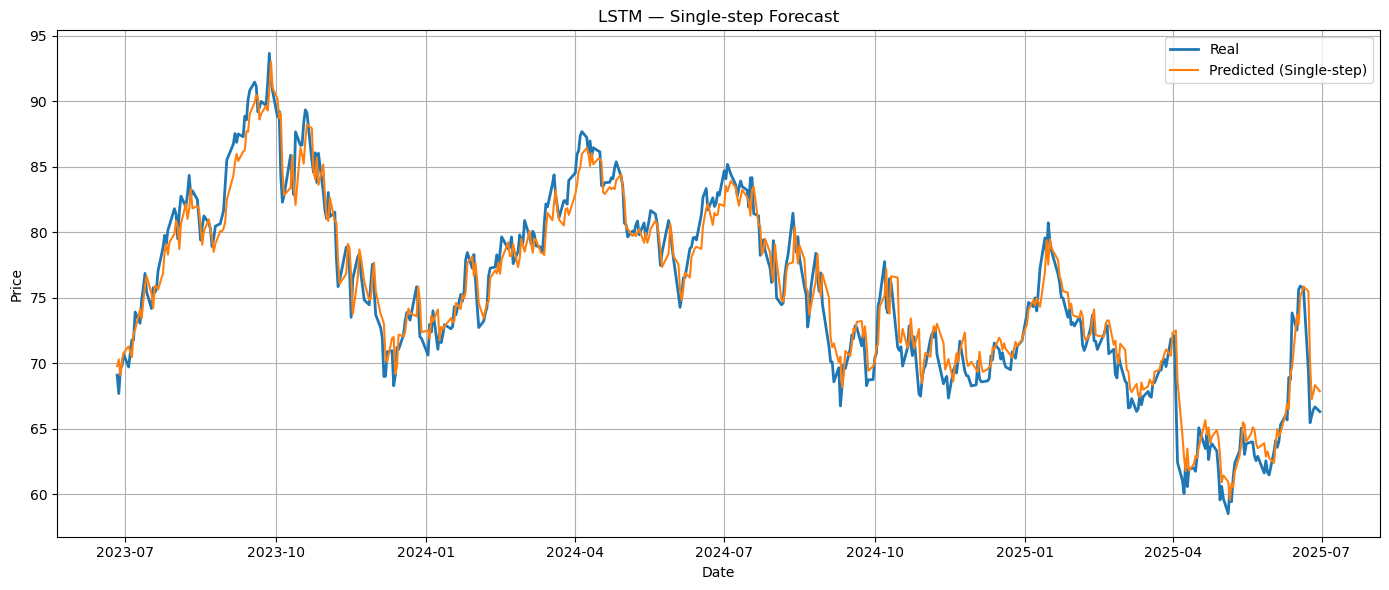

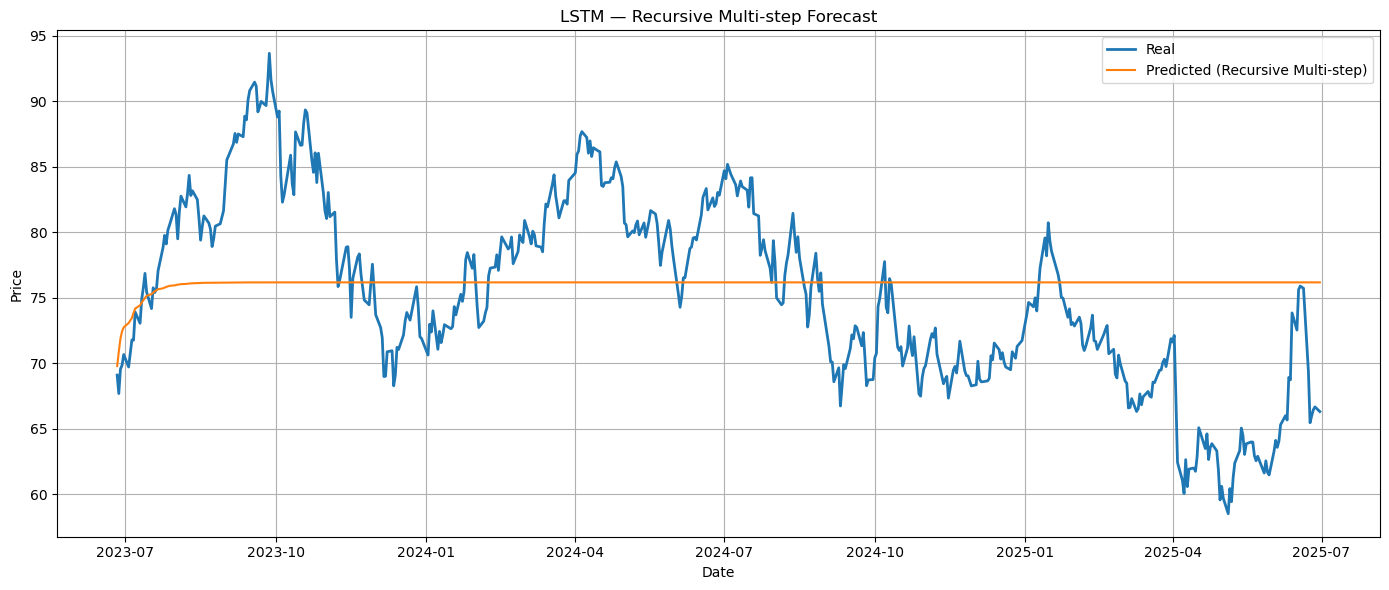

In [1]:
# -*- coding: utf-8 -*-
"""
LSTM Time Series Regression (PyTorch) — Outputs Both "Single-step" and "Recursive Multi-step" Results (80/20 Split)
-------------------------------------------------------------------------------
* Data Normalization: Z-score (StandardScaler), fitted only on training set (training subset) to avoid leakage
* Split: 80% training + 20% testing; 10% of training set used as validation for early stopping
* Model: Univariate LSTM → FC, hidden_size=32, num_layers=2, dropout=0.2
* Loss: HuberLoss (delta=1.0)
* Optimization: RMSprop (lr=1e-3, momentum=0.9)
* Evaluation: Single-step prediction & Recursive multi-step prediction (matching test set length)
* Visualization: Two separate plots (single-step / recursive multi-step)
Usage: Place oil_price_cleaned.csv in the same directory, containing columns ["Date","Price"]
"""

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ---------------- 0. Device and Random Seed ----------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ---------------- 1. Hyperparameters ----------------
CSV_PATH      = "oil_price_cleaned.csv"
TIMESTEPS     = 10
BATCH_SIZE    = 64
EPOCHS        = 120
LEARNING_RATE = 1e-3
PATIENCE      = 10          # Early-Stopping waiting rounds
VAL_RATIO     = 0.10        # 10% of training set for validation

# ---------------- 2. Load Data ----------------
try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    raise FileNotFoundError(f"{CSV_PATH} NOT found. Please keep the CSV in the same folder.")

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
price_series = df["Price"].astype(float).sort_index()  # Ensure time-ordered

# 80/20 split (time-ordered)
train_size = int(len(price_series) * 0.8)
train_series = price_series.iloc[:train_size]
test_series  = price_series.iloc[train_size:]

# Internal training set split for validation (time-ordered)
train_core_size = int(len(train_series) * (1 - VAL_RATIO))
train_core_series = train_series.iloc[:train_core_size]  # For fitting scaler + training
val_series        = train_series.iloc[train_core_size:]  # For early stopping validation

print(f"Train total: {len(train_series)} (train={len(train_core_series)}, val={len(val_series)}) | Test: {len(test_series)}")

# ---------------- 3. Normalization (fit only on train_core) ----------------
scaler = StandardScaler()
train_core_arr = train_core_series.values.reshape(-1, 1)
scaler.fit(train_core_arr)

# ---------------- 4. Sequence Creation Tools ----------------
def make_sequences(array: np.ndarray, timesteps: int):
    """array: normalized data with shape (n,1)"""
    X, y = [], []
    for i in range(timesteps, len(array)):
        X.append(array[i - timesteps : i, 0])
        y.append(array[i, 0])
    return np.array(X), np.array(y)

# Training set (train_core only)
train_core_scaled = scaler.transform(train_core_arr)
X_train, y_train = make_sequences(train_core_scaled, TIMESTEPS)

# Validation set (use train_core + val concatenated to generate windows, maintain time consistency)
val_arr = val_series.values.reshape(-1, 1)
combined_train_val = np.concatenate([train_core_arr, val_arr], axis=0)  # Concatenate in original scale
inputs_for_val = combined_train_val[len(combined_train_val) - len(val_series) - TIMESTEPS :]
inputs_for_val_scaled = scaler.transform(inputs_for_val)
X_val, y_val = make_sequences(inputs_for_val_scaled, TIMESTEPS)

# Test set (use train_total + test concatenated to generate windows, using true values for each window in single-step)
test_arr = test_series.values.reshape(-1, 1)
combined_train_test = np.concatenate([train_series.values.reshape(-1, 1), test_arr], axis=0)
inputs_for_test = combined_train_test[len(combined_train_test) - len(test_series) - TIMESTEPS :]
inputs_for_test_scaled = scaler.transform(inputs_for_test)
X_test, y_test = make_sequences(inputs_for_test_scaled, TIMESTEPS)

# Convert to Tensors
X_train_t = torch.from_numpy(X_train).float().view(-1, TIMESTEPS, 1)
y_train_t = torch.from_numpy(y_train).float().view(-1, 1)
X_val_t   = torch.from_numpy(X_val).float().view(-1, TIMESTEPS, 1)
y_val_t   = torch.from_numpy(y_val).float().view(-1, 1)
X_test_t  = torch.from_numpy(X_test).float().view(-1, TIMESTEPS, 1)
y_test_t  = torch.from_numpy(y_test).float().view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)

# ---------------- 5. Model ----------------
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int = 1, hidden_size: int = 32, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

model = LSTMRegressor().to(DEVICE)
print(model)

criterion = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# ---------------- 6. Training (with early stopping based on validation set) ----------------
best_val_loss = float("inf")
wait = 0

print("\n===== Training =====")
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t.to(DEVICE))
        val_loss = criterion(val_preds, y_val_t.to(DEVICE)).item()

    if epoch % 3 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{EPOCHS} | Train Loss: {epoch_loss:.5f} | Val Loss: {val_loss:.5f}")

    # Early-Stopping
    if val_loss < best_val_loss - 1e-6:  # Small threshold to avoid fluctuation
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"Training complete. Best Val Loss: {best_val_loss:.8f}")

# ---------------- 7. Evaluation Tools ----------------
def compute_metrics(y_true, y_pred):
    """y_true, y_pred are both original scale data with shape (n,1)"""
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    denom = np.where(np.abs(y_true) < 1e-8, 1e-8, np.abs(y_true))
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100
    return rmse, mae, mape

# ---------------- 8. Load Best Model and Make Predictions ----------------
model.load_state_dict(torch.load("best_model.pt", map_location=DEVICE))
model.eval()

# ---- 8.1 Single-step Prediction (each sample window uses true history) ----
with torch.no_grad():
    test_scaled_pred = model(X_test_t.to(DEVICE)).cpu().numpy()
pred_prices_single = scaler.inverse_transform(test_scaled_pred)          # Inverse transform
real_prices        = test_series.values.reshape(-1, 1)

rmse_s, mae_s, mape_s = compute_metrics(real_prices, pred_prices_single)

print("\n===== Evaluation (Single-step) =====")
print(f"RMSE: {rmse_s:.4f} | MAE: {mae_s:.4f} | MAPE: {mape_s:.2f}%")

# ---- 8.2 Recursive Multi-step Prediction (only starting point uses true values, rest use rolling predictions) ----
horizon = len(test_series)

# Initial window: last TIMESTEPS real values from training set before test set
start_window_real = train_series.values[-TIMESTEPS:].reshape(-1, 1)
window_scaled = scaler.transform(start_window_real.copy())

preds_scaled = []
with torch.no_grad():
    for _ in range(horizon):
        x = torch.from_numpy(window_scaled.reshape(1, TIMESTEPS, 1)).float().to(DEVICE)
        y_hat = model(x).cpu().numpy()  # Normalized space (1,1)
        preds_scaled.append(y_hat[0, 0])
        # Use prediction as input for next step, sliding window
        window_scaled = np.vstack([window_scaled[1:], [[y_hat[0, 0]]]])

pred_prices_multi = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1))

rmse_m, mae_m, mape_m = compute_metrics(real_prices, pred_prices_multi)

print("===== Evaluation (Recursive Multi-step) =====")
print(f"RMSE: {rmse_m:.4f} | MAE: {mae_m:.4f} | MAPE: {mape_m:.2f}%")

# ---------------- 9. Visualization ----------------
plt.figure(figsize=(14, 6))
plt.plot(test_series.index, real_prices, label="Real", linewidth=2)
plt.plot(test_series.index, pred_prices_single, label="Predicted (Single-step)")
plt.title("LSTM — Single-step Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(test_series.index, real_prices, label="Real", linewidth=2)
plt.plot(test_series.index, pred_prices_multi, label="Predicted (Recursive Multi-step)")
plt.title("LSTM — Recursive Multi-step Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
